In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
train = pd.read_csv('./Kannada-MNIST/train.csv')
test = pd.read_csv('./Kannada-MNIST/test.csv')

In [3]:
train.head(5)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


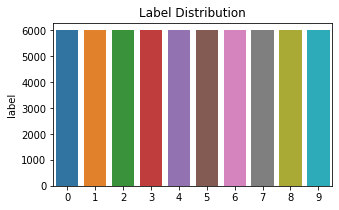

In [4]:
label_values = train['label'].value_counts().sort_index()
plt.figure(figsize=(5,3))
plt.title('Label Distribution')
sns.barplot(x=label_values.index, y=label_values)

In [5]:
img_train = train.drop(['label'], axis=1).values.reshape(-1,28,28,1).astype('float32')
img_label = train['label']
img_test = test.drop(['id'], axis=1).values.reshape(-1,28,28,1).astype('float32')
print("img_train.shape = ", img_train.shape)
print("img_label.shape = ", img_label.shape)
print("img_test.shape = ", img_test.shape)

img_train.shape =  (60000, 28, 28, 1)
img_label.shape =  (60000,)
img_test.shape =  (5000, 28, 28, 1)


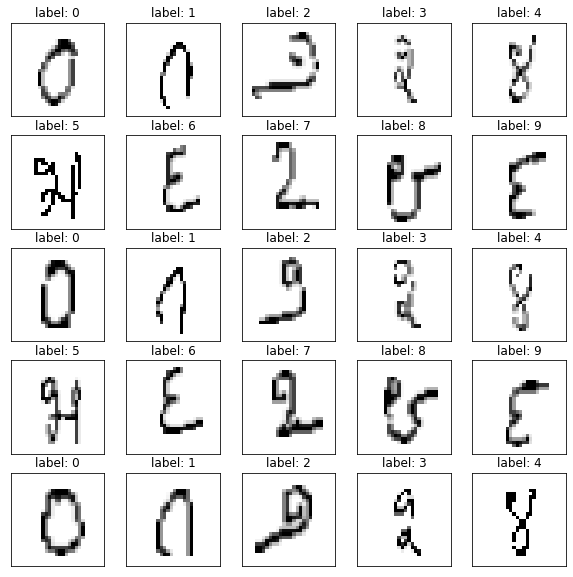

In [6]:
fig = plt.figure(figsize=(10,10))
show_img = 0
for idx in range(img_train.shape[0]):
    plt.subplot(5, 5, show_img + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img_train[idx].reshape(28, 28), cmap=plt.cm.binary)
    plt.title("label: %d" % img_label[idx])
    show_img += 1
    if show_img % 25 == 0:
        break

In [32]:
import torch.nn as nn

#28,28
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3),  # 16, 26 ,26
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True))

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3),  # 32, 24, 24
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2))  # 32, 12,12     (24-2) /2 +1

        self.dropout = nn.Dropout(p=0.4)  # dropout训练
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3),  # 64,10,10
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True))
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3),  # 128,8,8
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2))  # 128, 4,4

        self.fc = nn.Sequential(
            nn.Linear(128 * 4 * 4, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 10))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.dropout(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
model = CNN()
print(model)

CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dropout): Dropout(p=0.4, inplace=False)
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [33]:
import torch
import torch.utils.data
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import numpy as np

class MyDataset(torch.utils.data.Dataset):
    def __init__(self, file_path, transform=None):
        self.data = pd.read_csv(file_path)
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        # load image as ndarray type (Height * Width * Channels)
        # be carefull for converting dtype to np.uint8 [Unsigned integer (0 to 255)]
        # in this example, i don't use ToTensor() method of torchvision.transforms
        # so you can convert numpy ndarray shape to tensor in PyTorch (H, W, C) --> (C, H, W)
        image = self.data.iloc[index, 1:].values.astype(np.uint8).reshape((28, 28, 1))
        label = self.data.iloc[index, 0]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

In [34]:
#dataset augmentation
transform=transforms.Compose([
                            transforms.ToPILImage(),
                           # Add random transformations to the image.
                           transforms.RandomAffine(
                               degrees=20,
                               translate=(0.1, 0.2),
                               shear=(-10, 20, -10, 20),
                               scale=(0.60, 1.25)),

                           transforms.ToTensor()
                       ])

In [35]:
batch_size = 128
train_data = MyDataset('./Kannada-MNIST/train.csv', transform=transform)
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
val_data = MyDataset('./Kannada-MNIST/test.csv', transform=transform)
val_loader = DataLoader(dataset=val_data, batch_size=batch_size, shuffle=False)

In [36]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [37]:
epoch_num = 20
accuracy = []
losses = []
for epoch in range(epoch_num):
    train_correct = 0
    running_loss = 0
    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
        var_X_batch = Variable(X_batch).float()
        var_y_batch = Variable(y_batch)
        optimizer.zero_grad()
        
        output = model(var_X_batch)
        loss = criterion(output, var_y_batch)
        running_loss += loss.item()
        
        predicted = torch.max(output.data, 1)[1]
        train_correct += (predicted == var_y_batch).sum()
        batch_accuracy = float(train_correct*100) / float(batch_size*(batch_idx+1)) # in all trained data calculate the accracy
        accuracy.append(batch_accuracy)

        if batch_idx % 50 == 0:
            print('Epoch : {} [{}/{}]  Loss:{:.6f}  Accuracy:{:.2f}%'.format(
                epoch,
                batch_idx*len(X_batch), # how much data has been trained
                len(train_loader.dataset),
                loss.item(),
                batch_accuracy))
        loss.backward()
        optimizer.step()
        
    losses.append(running_loss)

Epoch : 0 [0/60000]  Loss:2.301094  Accuracy:10.16%
Epoch : 0 [6400/60000]  Loss:0.971189  Accuracy:42.56%
Epoch : 0 [12800/60000]  Loss:0.636527  Accuracy:58.06%
Epoch : 0 [19200/60000]  Loss:0.550742  Accuracy:66.14%
Epoch : 0 [25600/60000]  Loss:0.531707  Accuracy:71.33%
Epoch : 0 [32000/60000]  Loss:0.281061  Accuracy:74.84%
Epoch : 0 [38400/60000]  Loss:0.297034  Accuracy:77.34%
Epoch : 0 [44800/60000]  Loss:0.282913  Accuracy:79.31%
Epoch : 0 [51200/60000]  Loss:0.190412  Accuracy:80.88%
Epoch : 0 [57600/60000]  Loss:0.382254  Accuracy:82.14%
Epoch : 1 [0/60000]  Loss:0.148989  Accuracy:93.75%
Epoch : 1 [6400/60000]  Loss:0.276997  Accuracy:93.57%
Epoch : 1 [12800/60000]  Loss:0.170093  Accuracy:93.73%
Epoch : 1 [19200/60000]  Loss:0.188657  Accuracy:93.62%
Epoch : 1 [25600/60000]  Loss:0.119839  Accuracy:93.64%
Epoch : 1 [32000/60000]  Loss:0.154963  Accuracy:93.78%
Epoch : 1 [38400/60000]  Loss:0.186076  Accuracy:93.93%
Epoch : 1 [44800/60000]  Loss:0.066418  Accuracy:94.06%
Ep

In [38]:
def plot_loss_accuracy(loss, accuracy):
    fid = plt.figure(figsize=(20,5))

    Axes = plt.subplot(121, title="loss")
    Axes.axes.tick_params(which='both',direction='in',top=True, right=True)
    plt.minorticks_on()
    Axes.set_facecolor((0,0,0,0.02))
    # draw the line
    loss_X = np.arange(0,len(loss))
    plt.plot(loss_X, loss, 'k-', linewidth=3, color = 'r', label='loss')
    plt.grid(True,which='major',linewidth=0.5)
    plt.grid(True,which='minor',linewidth=0.1)
    plt.xlabel("epoch number")
    plt.ylabel("loss")
    plt.legend(loc='best',fontsize='x-small')
    plt.savefig('./loss.jpg')

    Axes = plt.subplot(122, title="accuracy")
    Axes.axes.tick_params(which='both',direction='in',top=True, right=True)
    plt.minorticks_on()
    Axes.set_facecolor((0,0,0,0.02))
    # draw the line
    accuracy_X = np.arange(0,len(accuracy))
    plt.plot(accuracy_X, accuracy, 'k-', linewidth=3, color = 'b', label='accuracy')
    plt.grid(True,which='major',linewidth=0.5)
    plt.grid(True,which='minor',linewidth=0.1)
    plt.xlabel("epoch number")
    plt.ylabel("accuracy")
    plt.legend(loc='best',fontsize='x-small')
    plt.savefig('./accuracy.jpg')

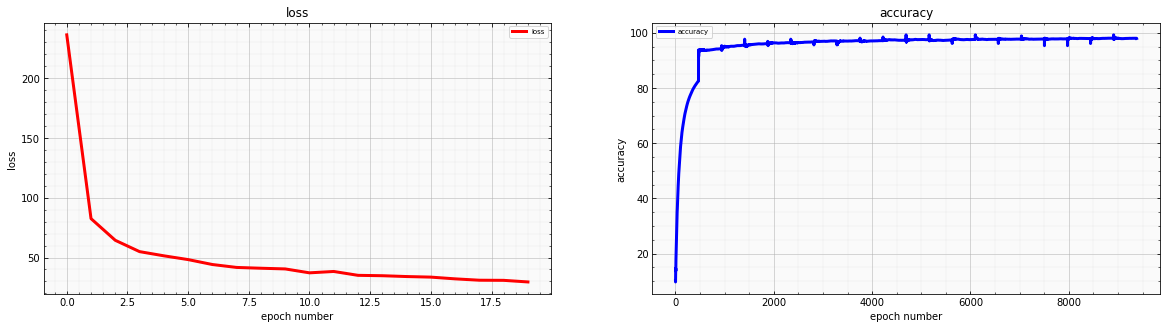

In [39]:
plot_loss_accuracy(losses, accuracy)

In [67]:
prediction = []
data_submission = pd.read_csv("./Kannada-MNIST/sample_submission.csv")
for idx, (test_data, y_label) in enumerate(val_loader):
    var_test_data = Variable(test_data).float()
    output = model(var_test_data)
    prediction.append(torch.max(output.data, 1)[1].numpy())

In [72]:
res = []
for i in prediction:
    for j in i:
        res.append(j)
data_submission['label'] = res
data_submission.to_csv('submission.csv',index=False)